# Bank Marketing
Using **XGBoost** for classification

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

In [2]:
df = pd.read_csv("./data/bank-additional-full.csv", delimiter=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Removing unuseful columns and rename the column names for better understanding.

`duration` (numeric) - last contact duration, in seconds.

**Important note:** this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call `y` is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [4]:
cols_to_drop = [
    "duration",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]
df = df.drop(columns=cols_to_drop)

new_column_names = {
    "job": "job_type",
    "default": "default_status",
    "housing": "housing_loan_status",
    "loan": "personal_loan_status",
    "contact": "contact_type",
    "month": "contact_month",
    "day_of_week": "contact_day_of_week",
    "campaign": "num_contacts",
    "pdays": "days_last_contact",
    "previous": "previous_contacts",
    "poutcome": "previous_outcome",
    "y": "result",
}
df = df.rename(columns=new_column_names)

Convert the binary values "yes" and "no" to numeric values 1 and 0

In [5]:
df["result"] = df["result"].replace({"yes": 1, "no": 0})

df.head()

,age,job_type,marital,education,default_status,housing_loan_status,personal_loan_status,contact_type,contact_month,contact_day_of_week,num_contacts,days_last_contact,previous_contacts,previous_outcome,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   41188 non-null  int64 
 1   job_type              41188 non-null  object
 2   marital               41188 non-null  object
 3   education             41188 non-null  object
 4   default_status        41188 non-null  object
 5   housing_loan_status   41188 non-null  object
 6   personal_loan_status  41188 non-null  object
 7   contact_type          41188 non-null  object
 8   contact_month         41188 non-null  object
 9   contact_day_of_week   41188 non-null  object
 10  num_contacts          41188 non-null  int64 
 11  days_last_contact     41188 non-null  int64 
 12  previous_contacts     41188 non-null  int64 
 13  previous_outcome      41188 non-null  object
 14  result                41188 non-null  int64 
dtypes: int64(5), object(10)
memory usage

## Identifying Missing Data

Check the unique values in 'object' columns:

In [7]:
print("All 'object' columns and their unique values")
i = 0
for col_name, d_type in zip(df.dtypes.index, df.dtypes.values):
    if d_type == "object":
        i += 1
        print(f"#{i} {col_name}:")
        print(df[col_name].unique())
        print("--------")

All 'object' columns and their unique values
#1 job_type:
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
--------
#2 marital:
['married' 'single' 'divorced' 'unknown']
--------
#3 education:
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
--------
#4 default_status:
['no' 'unknown' 'yes']
--------
#5 housing_loan_status:
['no' 'yes' 'unknown']
--------
#6 personal_loan_status:
['no' 'yes' 'unknown']
--------
#7 contact_type:
['telephone' 'cellular']
--------
#8 contact_month:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
--------
#9 contact_day_of_week:
['mon' 'tue' 'wed' 'thu' 'fri']
--------
#10 previous_outcome:
['nonexistent' 'failure' 'success']
--------


## Split the Date into Dependent and Independent Variables

In [8]:
X = df.drop("result", axis="columns").copy()
y = df["result"].copy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (41188, 14)
y shape: (41188,)


## One-Hot Encoding

We can use these two popular method for one-hot encoding:
- `ColumnTransformer()` from scikit-learn

- `get_dummies()` from pandas

In [9]:
categorical_columns = []
print("All 'object' columns and their unique values")
i = 0
for col_name, d_type in zip(X.dtypes.index, X.dtypes.values):
    if d_type == "object":
        i += 1
        print(f"#{i} {col_name}:")
        print(df[col_name].unique())
        print("--------")
        categorical_columns.append(col_name)

All 'object' columns and their unique values
#1 job_type:
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
--------
#2 marital:
['married' 'single' 'divorced' 'unknown']
--------
#3 education:
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
--------
#4 default_status:
['no' 'unknown' 'yes']
--------
#5 housing_loan_status:
['no' 'yes' 'unknown']
--------
#6 personal_loan_status:
['no' 'yes' 'unknown']
--------
#7 contact_type:
['telephone' 'cellular']
--------
#8 contact_month:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
--------
#9 contact_day_of_week:
['mon' 'tue' 'wed' 'thu' 'fri']
--------
#10 previous_outcome:
['nonexistent' 'failure' 'success']
--------


In [10]:
categorical_columns

['job_type',
 'marital',
 'education',
 'default_status',
 'housing_loan_status',
 'personal_loan_status',
 'contact_type',
 'contact_month',
 'contact_day_of_week',
 'previous_outcome']

In [11]:
X_encoded = pd.get_dummies(X, columns=categorical_columns, dtype=int)
X_encoded.head()

,age,num_contacts,days_last_contact,previous_contacts,job_type_admin.,job_type_blue-collar,job_type_entrepreneur,job_type_housemaid,job_type_management,job_type_retired,...,contact_month_oct,contact_month_sep,contact_day_of_week_fri,contact_day_of_week_mon,contact_day_of_week_thu,contact_day_of_week_tue,contact_day_of_week_wed,previous_outcome_failure,previous_outcome_nonexistent,previous_outcome_success
0,56,1,999,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## Split the data into training and testing dataset

In [12]:
sum(y) / len(y)

0.11265417111780131

11% of people in the dateset do not subscribed! So the data is very imbalanced.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test  shape: {y_test.shape}")

X_train shape: (30891, 57)
X_test  shape: (10297, 57)
y_train shape: (30891,)
y_test  shape: (10297,)


Verify that using `stratify` works as expected

In [14]:
sum(y_train) / len(y_train)

0.11265417111780131

In [15]:
sum(y_test) / len(y_test)

0.11265417111780131

## Building the `XGBoost` Model

In [16]:
sum(y_train == 0) / sum(y_train == 1)

7.876724137931035

In [17]:
clf_xgb_0 = XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight = 8, #recommended: sum(nagative instances) / sum(positive instances)
    seed=42,
    early_stopping_rounds=10,
    eval_metric="aucpr",
)

clf_xgb_0.fit(
    X_train,
    y_train,
    verbose=True,
    eval_set=[(X_test, y_test)],
)

[0]	validation_0-aucpr:0.38153
[1]	validation_0-aucpr:0.39180
[2]	validation_0-aucpr:0.41242
[3]	validation_0-aucpr:0.42341
[4]	validation_0-aucpr:0.42458
[5]	validation_0-aucpr:0.42681
[6]	validation_0-aucpr:0.43158
[7]	validation_0-aucpr:0.43074
[8]	validation_0-aucpr:0.42866
[9]	validation_0-aucpr:0.42990
[10]	validation_0-aucpr:0.43298
[11]	validation_0-aucpr:0.42911
[12]	validation_0-aucpr:0.42734
[13]	validation_0-aucpr:0.42594
[14]	validation_0-aucpr:0.42705
[15]	validation_0-aucpr:0.42691
[16]	validation_0-aucpr:0.42704
[17]	validation_0-aucpr:0.42619
[18]	validation_0-aucpr:0.42673
[19]	validation_0-aucpr:0.42599
[20]	validation_0-aucpr:0.42571


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [18]:
y_pred_0 = clf_xgb_0.predict(X_test)
report_0 = classification_report(y_test, y_pred_0)
print(report_0)

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      9137
           1       0.38      0.55      0.45      1160

    accuracy                           0.85     10297
   macro avg       0.66      0.72      0.68     10297
weighted avg       0.88      0.85      0.86     10297



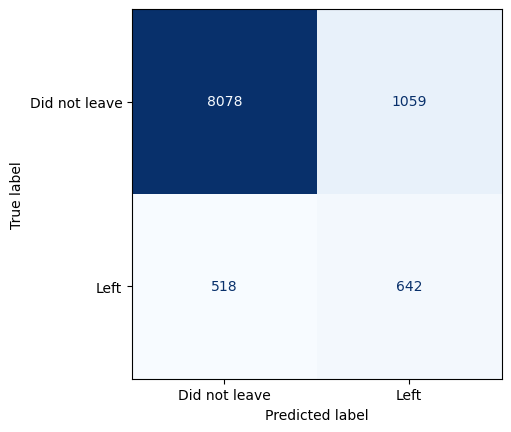

In [19]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_0,
    colorbar=False,
    cmap="Blues",
    display_labels=["Did not leave", "Left"],
);

## Using `SMOTE()` for oversampling the data

In [20]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f"X_train     shape: {X_train.shape}")
print(f"X_train_sm  shape: {X_train_sm.shape}")
print(f"y_train     shape: {y_train.shape}")
print(f"y_train_sm  shape: {y_train_sm.shape}")

X_train     shape: (30891, 57)
X_train_sm  shape: (54822, 57)
y_train     shape: (30891,)
y_train_sm  shape: (54822,)


In [21]:
sum(y_train_sm) / len(y_train_sm)

0.5

In [22]:
clf_xgb_1 = XGBClassifier(
    objective="binary:logistic",
    seed=42,
    early_stopping_rounds=10,
    eval_metric="aucpr",
)

clf_xgb_1.fit(
    X_train_sm,
    y_train_sm,
    verbose=True,
    eval_set=[(X_test, y_test)],
)

[0]	validation_0-aucpr:0.33124
[1]	validation_0-aucpr:0.38564
[2]	validation_0-aucpr:0.39260
[3]	validation_0-aucpr:0.41190
[4]	validation_0-aucpr:0.40050
[5]	validation_0-aucpr:0.41048
[6]	validation_0-aucpr:0.39571
[7]	validation_0-aucpr:0.39169
[8]	validation_0-aucpr:0.38779
[9]	validation_0-aucpr:0.39334
[10]	validation_0-aucpr:0.39755
[11]	validation_0-aucpr:0.39930
[12]	validation_0-aucpr:0.39722
[13]	validation_0-aucpr:0.40157


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
y_pred_1 = clf_xgb_1.predict(X_test)
report_1 = classification_report(y_test, y_pred_1)
print(report_1)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      9137
           1       0.41      0.50      0.45      1160

    accuracy                           0.86     10297
   macro avg       0.67      0.70      0.69     10297
weighted avg       0.88      0.86      0.87     10297



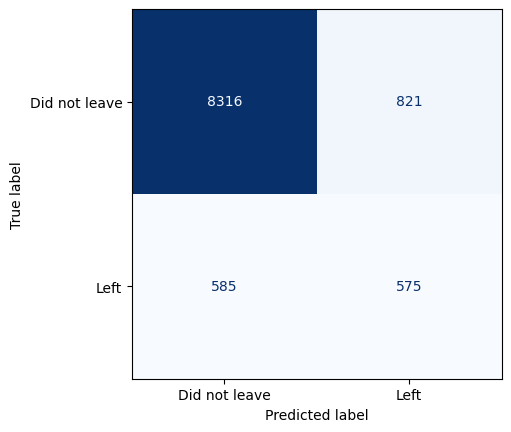

In [25]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_1,
    colorbar=False,
    cmap="Blues",
    display_labels=["Did not leave", "Left"],
);

## Optimize Parameters using Cross Validation and `GridSearchCV()`

In [46]:
param_grid = {
    "max_depth": [5, 6],
    "learning_rate": [0.1, 0.5],
    "gamma": [0, 0.5],
    "reg_lambda": [4, 5],
    "scale_pos_weight": [3, 4, 5],
}

optimal_params = GridSearchCV(
    estimator=XGBClassifier(
        objective="binary:logistic",
        seed=42,
        early_stopping_rounds=10,
        eval_metric="auc",
        subsample=0.9,
        colsample_bytree=0.5,
    ),
    param_grid=param_grid,
    scoring="roc_auc",
    verbose=2,
    n_jobs=-1,
    cv=3,
)

optimal_params.fit(
    X_train_sm, y_train_sm,
    eval_set=[(X_test, y_test)],
)
print(optimal_params.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[0]	validation_0-auc:0.69532
[1]	validation_0-auc:0.69847
[2]	validation_0-auc:0.71493
[3]	validation_0-auc:0.73262
[4]	validation_0-auc:0.73960
[0]	validation_0-auc:0.71503
[5]	validation_0-auc:0.74351
[6]	validation_0-auc:0.74308
[1]	validation_0-auc:0.71589
[7]	validation_0-auc:0.74738
[8]	validation_0-auc:0.74904
[2]	validation_0-auc:0.72342
[9]	validation_0-auc:0.75358
[10]	validation_0-auc:0.75262
[3]	validation_0-auc:0.74210
[11]	validation_0-auc:0.75216
[4]	validation_0-auc:0.74943
[12]	validation_0-auc:0.75194
[5]	validation_0-auc:0.75293
[13]	validation_0-auc:0.75274
[6]	validation_0-auc:0.75487
[14]	validation_0-auc:0.75601
[15]	validation_0-auc:0.75682
[7]	validation_0-auc:0.75882
[8]	validation_0-auc:0.75852
[16]	validation_0-auc:0.75822
[9]	validation_0-auc:0.76472
[17]	validation_0-auc:0.75910
[10]	validation_0-auc:0.76539
[18]	validation_0-auc:0.75813
[11]	validation_0-auc:0.76523
[19]	validation_0-auc:0.76022
[12]	validation_0-auc:0.76529
[20]	validation_0-auc:0.75957


## Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model

In [47]:
clf_xgb_best = XGBClassifier(
    objective="binary:logistic",
    seed=42,
    early_stopping_rounds=10,
    eval_metric="aucpr",
    max_depth=6,
    learning_rate=0.5,
    gamma=0.5,
    reg_lambda=5,
    scale_pos_weight=5,
)

clf_xgb_best.fit(
    X_train_sm,
    y_train_sm,
    verbose=True,
    eval_set=[(X_test, y_test)],
)

[0]	validation_0-aucpr:0.30181
[1]	validation_0-aucpr:0.34422
[2]	validation_0-aucpr:0.37594
[3]	validation_0-aucpr:0.39120
[4]	validation_0-aucpr:0.39056
[5]	validation_0-aucpr:0.39147
[6]	validation_0-aucpr:0.39007
[7]	validation_0-aucpr:0.39062
[8]	validation_0-aucpr:0.39422
[9]	validation_0-aucpr:0.39579
[10]	validation_0-aucpr:0.39209
[11]	validation_0-aucpr:0.39315
[12]	validation_0-aucpr:0.39679
[13]	validation_0-aucpr:0.39738
[14]	validation_0-aucpr:0.40236
[15]	validation_0-aucpr:0.40275
[16]	validation_0-aucpr:0.40443
[17]	validation_0-aucpr:0.40352
[18]	validation_0-aucpr:0.40714
[19]	validation_0-aucpr:0.40704
[20]	validation_0-aucpr:0.40861
[21]	validation_0-aucpr:0.40592
[22]	validation_0-aucpr:0.40614
[23]	validation_0-aucpr:0.40363
[24]	validation_0-aucpr:0.40491
[25]	validation_0-aucpr:0.40532
[26]	validation_0-aucpr:0.40711
[27]	validation_0-aucpr:0.40745
[28]	validation_0-aucpr:0.40651
[29]	validation_0-aucpr:0.40606
[30]	validation_0-aucpr:0.40617


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [48]:
y_pred_best = clf_xgb_best.predict(X_test)
report_best = classification_report(y_test, y_pred_best)
print(report_best)

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      9137
           1       0.29      0.61      0.39      1160

    accuracy                           0.79     10297
   macro avg       0.62      0.71      0.63     10297
weighted avg       0.87      0.79      0.82     10297



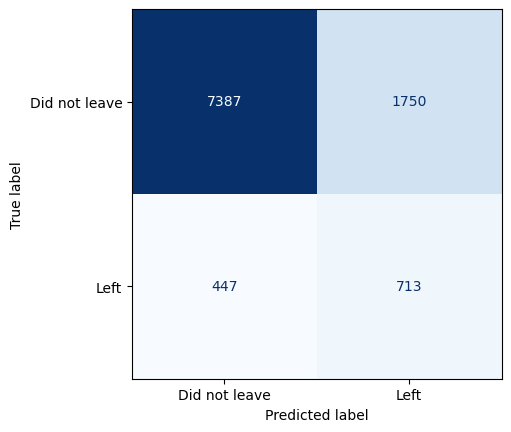

In [49]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_best,
    colorbar=False,
    cmap="Blues",
    display_labels=["Did not leave", "Left"],
);

## Comparing models

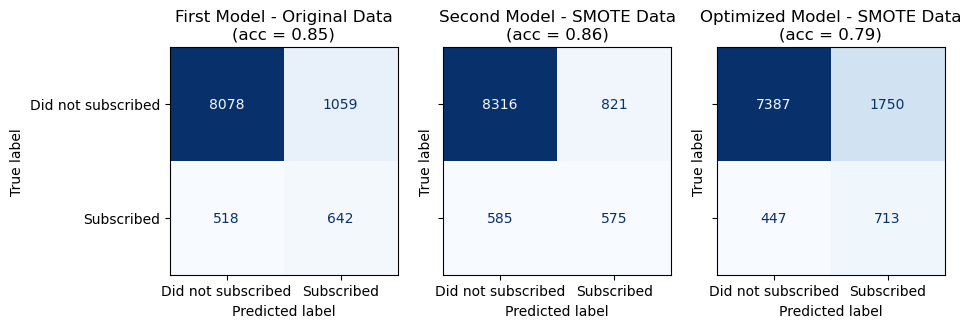

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_0,
    colorbar=False,
    cmap="Blues",
    display_labels=["Did not subscribed", "Subscribed"],
    ax=axes[0],
)
acc_0 = accuracy_score(y_test, y_pred_0)
axes[0].set_title(f"First Model - Original Data\n(acc = {acc_0:.2f})")

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_1,
    colorbar=False,
    cmap="Blues",
    display_labels=["Did not subscribed", "Subscribed"],
    ax=axes[1],
)
acc_1 = accuracy_score(y_test, y_pred_1)
axes[1].set_title(f"Second Model - SMOTE Data\n(acc = {acc_1:.2f})")

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_best,
    colorbar=False,
    cmap="Blues",
    display_labels=["Did not subscribed", "Subscribed"],
    ax=axes[2],
)
acc_best = accuracy_score(y_test, y_pred_best)
axes[2].set_title(f"Optimized Model - SMOTE Data\n(acc = {acc_best:.2f})");

Although the accuary becomes less, but recall for people who subscribed is higher.